In [ ]:
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 9.2 MB/s eta 0:00:00


In [ ]:
!pip install torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2 as cv
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.Unet(                   # use Unet because it's good for segmentation
    encoder_name="mobilenet_v2",    # choosing mobilenet_v2 encoder because it's more lightweight
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=4,                      # model output channels (number of classes in your dataset)
).to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/artificial-lunar-rocky-landscape-dataset/model/unet_lunar_segmentation.pth"))

<All keys matched successfully>

In [ ]:
class LunarDataset(Dataset):
  def __init__(self, images_dir, masks_dir, transform=None):
    # get the directory of the images and masks
    self.images_dir = images_dir
    self.masks_dir = masks_dir
    # get the list of images and masks
    self.images_list = sorted(os.listdir(images_dir))
    self.masks_list = sorted(os.listdir(masks_dir))
    # transform
    self.transform = transform

  def __len__(self):
    return len(self.images_list)

  def __getitem__(self, index):
    # get the path of item
    img_path = os.path.join(self.images_dir, self.images_list[index])
    mask_path = os.path.join(self.masks_dir, self.masks_list[index])
    # read it unchanged
    img = cv.imread(img_path, cv.IMREAD_UNCHANGED)
    mask = cv.imread(mask_path, cv.IMREAD_UNCHANGED)
    # convert to torch tensors
    img_tensor = torch.from_numpy(img).permute(2,0,1).float() / 255.0 # change [480, 720, 3] to [3, 480, 720] and float32 and normalizes
    mask_tensor = torch.from_numpy(mask).long()
    # optional transform
    if self.transform:
      img = self.transform(img)

    return (img_tensor, mask_tensor)

In [ ]:
image_test_folder = "/content/drive/MyDrive/artificial-lunar-rocky-landscape-dataset/images/test"
mask_test_folder = "/content/drive/MyDrive/artificial-lunar-rocky-landscape-dataset/masks_clean/test"

In [ ]:
test_dataset = LunarDataset(image_test_folder, mask_test_folder, transform=None)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
import numpy as np

NUM_CLASSES = 4

@torch.no_grad()
def compute_mIoU(model, loader, num_classes=NUM_CLASSES, device=device):
    model.eval()
    intersection = np.zeros(num_classes, dtype=np.float64)
    union = np.zeros(num_classes, dtype=np.float64)

    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)                 # [B, C, H, W]
        preds = torch.argmax(outputs, dim=1)    # [B, H, W]

        for p, t in zip(preds, masks):
            p = p.cpu().numpy()
            t = t.cpu().numpy()
            for c in range(num_classes):
                p_c = (p == c)
                t_c = (t == c)
                intersection[c] += np.logical_and(p_c, t_c).sum()
                union[c] += np.logical_or(p_c, t_c).sum()

    iou_per_class = intersection / (union + 1e-7)
    mean_iou = np.nanmean(iou_per_class)

    print("Per-class IoU:", np.round(iou_per_class, 4))
    print("Mean IoU:", round(mean_iou, 4))
    return iou_per_class, mean_iou

iou_per_class, mean_iou = compute_mIoU(model, test_loader)

Per-class IoU: [0.9318 0.9687 0.5668 0.305 ]
Mean IoU: 0.6931


that took 15 minutes to do

Per-class IoU: [0.9318 0.9687 0.5668 0.305 ] <br>
Mean IoU: 0.6931

good at ground and sky, bad at rocks



In [ ]:
def preprocess_image(img_path):
  import cv2 as cv
  import numpy as np
  img = cv.imread(img_path, cv.IMREAD_UNCHANGED)
  img_tensor = torch.from_numpy(img).permute(2,0,1).float() / 255.0
  img_tensor = img_tensor.unsqueeze(0)

  return img_tensor

In [ ]:
@torch.no_grad()
def predict_mask(model, img_tensor):
    output = model(img_tensor)             # [1, num_classes, H, W]
    pred = torch.argmax(output, dim=1)     # [1, H, W]
    return pred.squeeze(0).cpu().numpy()   # [H, W]

In [ ]:
# 4 classes example (background, rock, crater, shadow)
PALETTE = np.array([
    [0,   0,   0  ],  # class 0 - black - ground
    [255, 0,   0  ],  # class 1 - red - sky
    [0,   255, 0 ],   # class 2 - green - small rock
    [0, 0,   255  ],  # class 3 - red - big rock
], dtype=np.uint8)

def decode_mask(mask):
    return PALETTE[mask]

In [ ]:
def visualize_inference(image_paths):
    model.eval()
    for img_path in image_paths:
        img_tensor = preprocess_image(img_path)
        img_tensor = img_tensor.to(device)
        pred_mask = predict_mask(model, img_tensor)

        # reload original image for display
        original = cv.imread(img_path)
        original = cv.cvtColor(original, cv.COLOR_BGR2RGB)

        # decode mask to color image
        color_mask = decode_mask(pred_mask)

        # plot
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(original)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(color_mask)
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.tight_layout()
        plt.show()


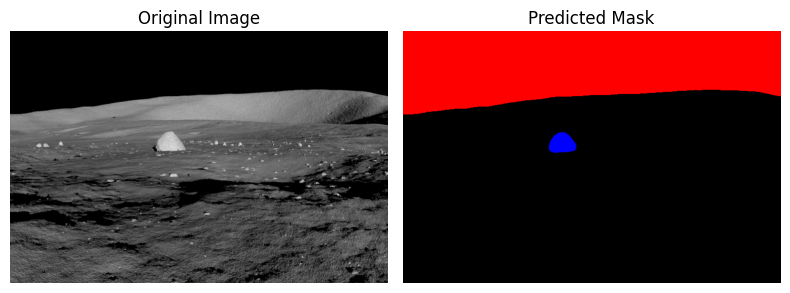

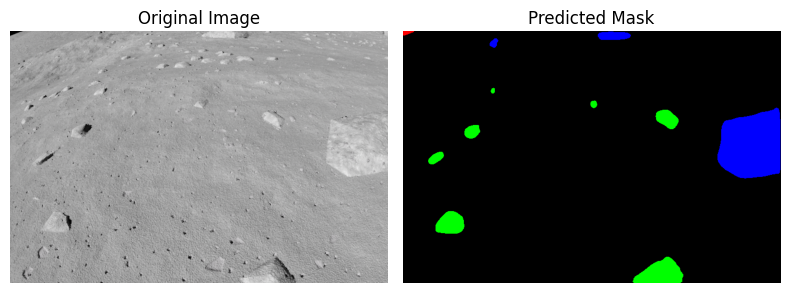

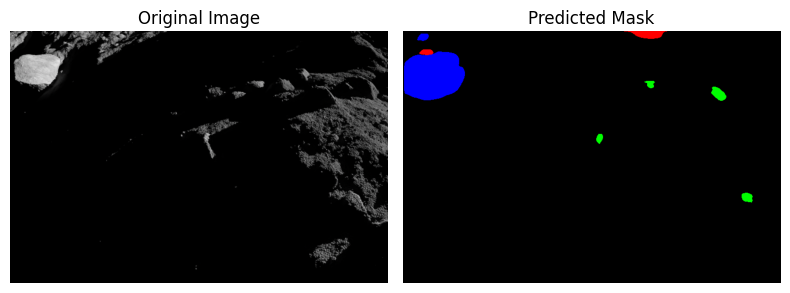

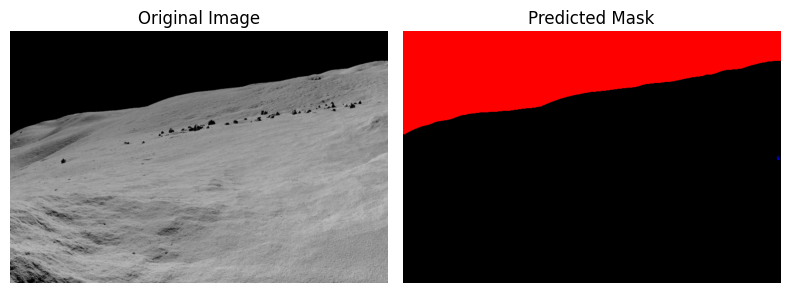

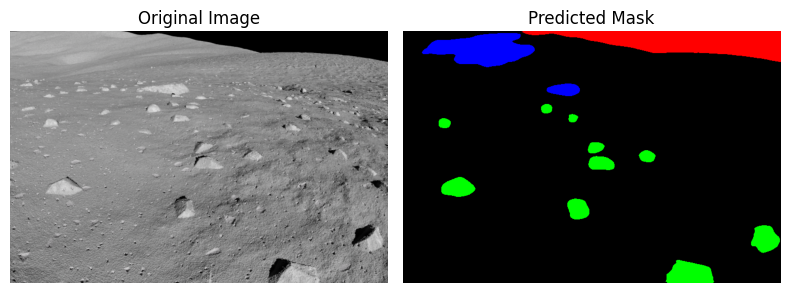

In [ ]:
image_paths = sorted([os.path.join(image_test_folder, i) for i in os.listdir(image_test_folder)])[:5]
visualize_inference(image_paths)

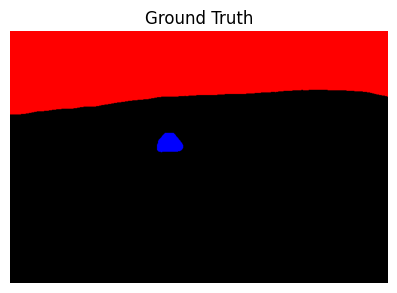

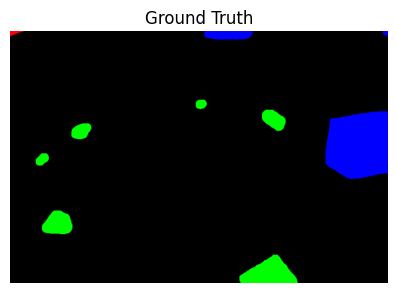

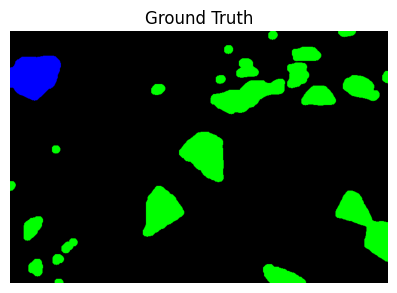

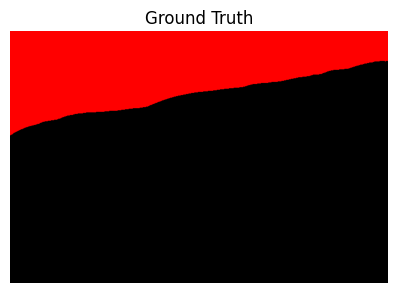

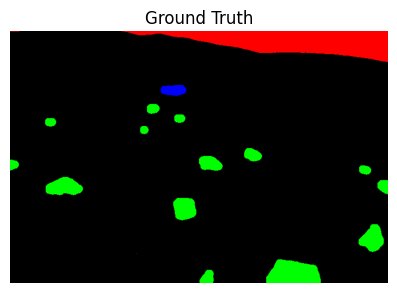

In [ ]:
mask_paths = sorted([os.path.join(mask_test_folder, i) for i in os.listdir(mask_test_folder)])[:5]

for mask_path in mask_paths:
  mask = cv.imread(mask_path, cv.IMREAD_UNCHANGED)
  color_mask = decode_mask(mask)

  plt.figure(figsize=(8, 4))
  plt.subplot(1, 2, 1)
  plt.imshow(color_mask)
  plt.title("Ground Truth")
  plt.axis("off")

  plt.tight_layout()
  plt.show()